In [13]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import networkx as nx
from multiprocessing import Pool
import pandas as pd
from scipy import stats
from matplotlib.lines import Line2D
from scipy.stats import spearmanr, pearsonr
import pickle
%pylab inline

def Deqs(x, t, A, rho, nu, M0):

    N = A.shape[0]
    numerator = (np.multiply(M0, 1 + np.sum(A, axis=1)) + np.multiply(nu, x) + np.multiply((nu+1),(A.dot(x))))
    denominator = ( np.multiply(1.*rho,t) + (A + np.identity(N)).dot(M0 + np.multiply((nu+1), x)))
    #dxdt = numerator/denominator
    dxdt = numerator/denominator
    
    return dxdt

def get_heaps_UMT(G, rho, nu, M0, tmax=10000):
    
    A = nx.to_numpy_array(G)
    N = A.shape[0]

    x0 = [0]*N
    t = np.arange(tmax)

    params = (A, rho, nu, M0)
    res = odeint(Deqs, x0, t, args=params)

    analytical_heaps={i: res[:,i] for i in range(N)} 
    
    return t, analytical_heaps

def reduce_number_of_points(x,y,bins):
    bin_means, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='mean', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return bin_centers, bin_means

def get_alpha_centrality(G, alpha):
    A = nx.to_numpy_matrix(G)
    alpha = float(alpha)
    res = np.linalg.inv((np.identity(A.shape[0]) - alpha*A)).dot(np.ones(A.shape[0]))
    return {n:r for n, r in enumerate(np.array(res).flatten())}

Populating the interactive namespace from numpy and matplotlib


# Heaps law and centrality in empirical networks

## (a) Zachary Karate Club (ZKC)

In [14]:
G = nx.karate_club_graph()

In [36]:
print(G.order(), G.size(), 1.*sum(dict(G.degree()).values())/G.order(), max(abs(numpy.linalg.eig(nx.to_numpy_matrix(G))[0])))

34 78 4.58823529412 6.725697727631747


In [15]:
#Model parameters
rho = 10
nu = 1
M0 = nu+1
tmax = 10000

#Solving the model analytically 
t, analytical_heaps = get_heaps_UMT(G, rho, nu, M0, tmax=tmax)

#Extracting the S(t_max)
D_tmax = {node:yana[-1] for node, yana in analytical_heaps.items()}

#Calculating the rough beta fit with the log method
betas = {n: np.log10(D)/np.log10(tmax) for n, D in D_tmax.items()}

In [ ]:
#Extracting the alpha centrality of G for different values of alpha
alphas = np.linspace(0,0.3,200)
spcorr = []
for alpha in alphas:
    ac = get_alpha_centrality(G, alpha=alpha)    
    spcorr.append(spearmanr(betas.values(), ac.values())[0])

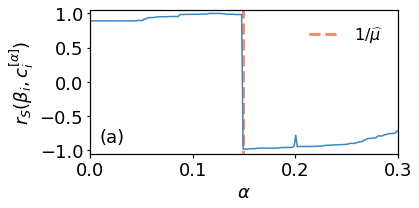

In [5]:
fig = plt.figure(figsize=(6,3));

plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 1.2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2
mycolor = [0.21568627, 0.52941176, 0.75424837, 1.        ]

ax = plt.subplot(111)

ax.axvline(x = 1./max(abs(numpy.linalg.eig(nx.to_numpy_matrix(G))[0])), 
           ymin = -1.05, ymax = 1.05,
           linestyle='--', color=plt.cm.Reds(0.4), lw=3, label=ur'$1/\widehat{\mu}$')

ax.plot(alphas, spcorr, '-', color=mycolor)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel(r"$\alpha$", size=18)
ax.set_ylabel(r"$r_{S}(\beta_i,c^{[\alpha]}_i)$", size=18)
ax.set_ylim(-1.05,1.05)
plt.yticks(np.arange(-1.,1.5, 0.5))
ax.set_xlim(min(alphas), max(alphas))
ax.legend(fontsize=16, frameon=False);
ax.annotate('(a)', xy=(0.03, 0.08), xycoords="axes fraction", fontsize=18);

plt.tight_layout()

In [16]:
chosen_alpha = .85/max(abs(numpy.linalg.eig(nx.to_numpy_matrix(G))[0]))
print(chosen_alpha)

0.12638093985518764


In [21]:
df = pd.DataFrame() 
df['node_id'] = list(D_tmax.keys())
df['D_tmax'] = list(D_tmax.values())
df['alpha_c'] = list(get_alpha_centrality(G, alpha=chosen_alpha).values())
#Adding normalized centrality
df['normed_alpha_c'] = df['alpha_c']/df['alpha_c'].max()
#Adding fitted beta exponent (with the rough log method)
df['beta_exp_rough'] = list(betas.values())

#Saving
df.to_csv('../results/Real_nets/Karate_club.csv', index=False, header=True, sep=',')

df.head()

,node_id,D_tmax,alpha_c,normed_alpha_c,beta_exp_rough
0,0,4226.764860,11.463464,0.962196,0.906502
1,1,3383.630858,8.385914,0.703880,0.882346
2,2,3756.965776,9.766867,0.819791,0.893709
3,3,2834.807310,6.765716,0.567887,0.863131
4,4,1424.068479,3.317682,0.278473,0.788383


## (b) Twitter

In [218]:
G = nx.read_edgelist("../data/twitter_social.tsv", comments='%')
print(G.order(), G.size())
print(nx.is_weighted(G), nx.is_directed(G))

465017 833540
False False


Sampling it to reduce the number of nodes

In [219]:
import itertools
def random_walk_generator(G):
    v = np.random.choice(list(G.nodes()))
    for _ in itertools.count():
        v = np.random.choice(list(G.neighbors(v)))
        yield v

n_nodes_to_sample = 8000 #this is the number of steps, there will be less nodes of course
generator = random_walk_generator(G)
random_walk_sample = [ next(generator) for step in range(0, n_nodes_to_sample)]
#from the path to the new set of nodes
sampled_nodes = list(set(random_walk_sample))
print(len(sampled_nodes))

4968


In [220]:
G = nx.subgraph(G, sampled_nodes)
print(G.order(), G.size())
print(nx.is_connected(G))
print(nx.is_weighted(G), nx.is_directed(G))

4968 26294
True
False False


Reading again as a directed graph and filtering

In [221]:
G = nx.read_edgelist("../data/twitter_social.tsv", comments='%', create_using=nx.DiGraph())
G = nx.subgraph(G, sampled_nodes)
print(G.order(), G.size())
print(nx.is_weighted(G), nx.is_directed(G))

4968 26875
False True


Saving the filtered network

In [222]:
nx.write_edgelist(G, "../data/twitter_social_filtered.tsv")

### Reading filtered Twitter graph

In [22]:
G = nx.read_edgelist("../data/twitter_social_filtered.tsv", create_using=nx.DiGraph())

In [3]:
print(G.order(), G.size(), 1.*sum(dict(G.degree()).values())/G.order(), max(abs(numpy.linalg.eig(nx.to_numpy_matrix(G))[0])))

4968 26875 10.8192431562 5.232288805143486


In [3]:
nx.number_strongly_connected_components(G)

4164

In [4]:
Gcc = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
G0.order()

770

In [23]:
#Model parameters
rho = 10
nu = 1
M0 = nu+1
tmax = 10000

#Solving the model analytically 
t, analytical_heaps = get_heaps_UMT(G, rho, nu, M0, tmax=tmax)

#Extracting the S(t_max)
D_tmax = {node:yana[-1] for node, yana in analytical_heaps.items()}

#Calculating the rough beta fit with the log method
betas = {n: np.log10(D)/np.log10(tmax) for n, D in D_tmax.items()}

In [ ]:
#Extracting the alpha centrality of G for different values of alpha
alphas = np.linspace(0,0.4,200)
spcorr = []
for alpha in alphas:
    ac = get_alpha_centrality(G, alpha=alpha)    
    spcorr.append(spearmanr(betas.values(), ac.values())[0])

In [ ]:
fig = plt.figure(figsize=(6,3));

plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 1.2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2
mycolor = [0.21568627, 0.52941176, 0.75424837, 1.        ]

ax = plt.subplot(111)

ax.axvline(x = 1./max(abs(numpy.linalg.eig(nx.to_numpy_matrix(G))[0])), 
           ymin = -1.05, ymax = 1.05,
           linestyle='--', color=plt.cm.Reds(0.4), lw=3, label=ur'$1/\widehat{\mu}$')

ax.plot(alphas, spcorr, '-', color=mycolor)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel(r"$\alpha$", size=18)
ax.set_ylabel(r"$r_{S}(\beta_i,c^{[\alpha]}_i)$", size=18)
ax.set_ylim(-1.05,1.05)
plt.yticks(np.arange(-1.,1.5, 0.5))
ax.set_xlim(min(alphas), max(alphas))
ax.legend(fontsize=16, frameon=False);
ax.annotate('(b)', xy=(0.03, 0.08), xycoords="axes fraction", fontsize=18);

plt.tight_layout()

In [25]:
chosen_alpha = .85/max(abs(numpy.linalg.eig(nx.to_numpy_matrix(G))[0]))
print(chosen_alpha)

0.16245280634440834


In [26]:
df = pd.DataFrame() 
df['node_id'] = list(D_tmax.keys())
df['D_tmax'] = list(D_tmax.values())
df['alpha_c'] = list(get_alpha_centrality(G, alpha=chosen_alpha).values())
#Adding normalized centrality
df['normed_alpha_c'] = df['alpha_c']/df['alpha_c'].max()
#Adding fitted beta exponent (with the rough log method)
df['beta_exp_rough'] = np.log10(df['D_tmax'])/np.log10(tmax)

#Saving
df.to_csv('../results/Real_nets/Twitter.csv', index=False, header=True, sep=',')

df.head()

,node_id,D_tmax,alpha_c,normed_alpha_c,beta_exp_rough
0,0,589.777025,5.128416,0.042854,0.692672
1,1,1112.958907,11.338008,0.094743,0.761620
2,2,806.155929,7.587651,0.063404,0.726605
3,3,3.783789,1.000000,0.008356,0.144482
4,4,24.730465,1.487358,0.012429,0.348308


## (c) NetSci collaboration net

In [27]:
G = nx.read_gml("../data/netscience2006/netscience.gml")
print(G.order(), G.size())
print(nx.is_connected(G))
print(nx.is_weighted(G), nx.is_directed(G))
print(nx.number_connected_components(G))

1589 2742
False
False False
396


In [8]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
G0.order()

379

In [7]:
print(G.order(), G.size(), 1.*sum(dict(G.degree()).values())/G.order(), max(abs(numpy.linalg.eig(nx.to_numpy_matrix(G))[0])))

1589 2742 3.45122718691 19.023813977135763


In [28]:
#Model parameters
rho = 10
nu = 1
M0 = nu+1
tmax = 10000

#Solving the model analytically 
t, analytical_heaps = get_heaps_UMT(G, rho, nu, M0, tmax=tmax)

#Extracting the S(t_max)
D_tmax = {node:yana[-1] for node, yana in analytical_heaps.items()}

#Calculating the rough beta fit with the log method
betas = {n: np.log10(D)/np.log10(tmax) for n, D in D_tmax.items()}

In [11]:
#Extracting the alpha centrality of G for different values of alpha
alphas = np.linspace(0,0.15,200)
spcorr = []
for alpha in alphas:
    ac = get_alpha_centrality(G, alpha=alpha)    
    spcorr.append(spearmanr(betas.values(), ac.values())[0])

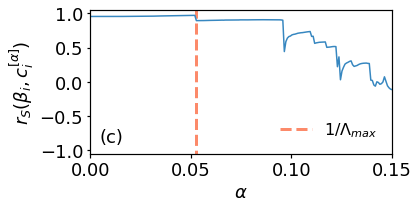

In [15]:
fig = plt.figure(figsize=(6,3));

plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 1.2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2
mycolor = [0.21568627, 0.52941176, 0.75424837, 1.        ]

ax = plt.subplot(111)

ax.axvline(x = 1./max(abs(numpy.linalg.eig(nx.to_numpy_matrix(G))[0])), 
           ymin = -1.05, ymax = 1.05,
           linestyle='--', color=plt.cm.Reds(0.4), lw=3, label=ur'$1/\Lambda_{max}$')

ax.plot(alphas, spcorr, '-', color=mycolor)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel(r"$\alpha$", size=18)
ax.set_ylabel(r"$r_{S}(\beta_i,c^{[\alpha]}_i)$", size=18)
ax.set_ylim(-1.05,1.05)
plt.yticks(np.arange(-1.,1.5, 0.5))
ax.set_xlim(min(alphas), max(alphas))
ax.legend(fontsize=16, frameon=False);
ax.annotate('(c)', xy=(0.03, 0.08), xycoords="axes fraction", fontsize=18);

plt.tight_layout()

In [29]:
chosen_alpha = .85/max(abs(numpy.linalg.eig(nx.to_numpy_matrix(G))[0]))
print(chosen_alpha)

0.04468084060439149


In [30]:
df = pd.DataFrame() 
df['node_id'] = list(D_tmax.keys())
df['D_tmax'] = list(D_tmax.values())
df['alpha_c'] = list(get_alpha_centrality(G, alpha=chosen_alpha).values())
#Adding normalized centrality
df['normed_alpha_c'] = df['alpha_c']/df['alpha_c'].max()
#Adding fitted beta exponent (with the rough log method)
df['beta_exp_rough'] = np.log10(df['D_tmax'])/np.log10(tmax)

#Saving
df.to_csv('../results/Real_nets/NetSci2006_collaboration.csv', index=False, header=True, sep=',')

df.head()

,node_id,D_tmax,alpha_c,normed_alpha_c,beta_exp_rough
0,0,129.892034,1.100337,0.162442,0.528396
1,1,153.498572,1.145295,0.169079,0.546526
2,2,917.641317,1.217617,0.179756,0.740668
3,3,917.641317,1.217617,0.179756,0.740668
4,4,917.641317,1.217617,0.179756,0.740668


In [6]:
NetSci = pd.read_csv('../results/Real_nets/NetSci2006_collaboration.csv')

In [32]:
pos = nx.spring_layout(G, k=2/sqrt(G.order()))

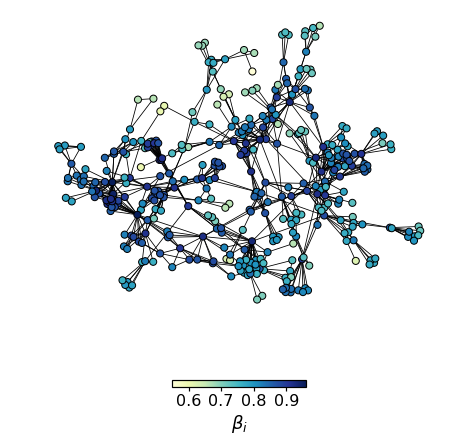

In [42]:
fig = plt.figure(figsize=(8,8));

plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 1.2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2
ax = plt.subplot(111, aspect='equal')

colors = np.array(NetSci['beta_exp_rough'])
cmap = plt.cm.YlGnBu
vmin, vmax = min(colors), max(colors)

nx.draw_networkx_edges(G, pos=pos, width=0.8, arrowstyle='-|>', arrowsize=20);
nx.draw_networkx_nodes(G, pos=pos, node_color=colors, cmap=cmap, vmin=vmin, vmax=vmax,
                       node_size=50, edgecolors='Black', linewidths=1);

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', ticks=[0.5,0.6,0.7,0.8,0.9], shrink=0.3)
                    #, fraction=0.015, pad=0.02, ticks=[0.7,0.8,0.9])
ticklabs = cbar.ax.get_xticklabels()
cbar.ax.set_xticklabels(ticklabs, fontsize=16)
#cbar = fig.colorbar(im, cax=cbar_axim, ticks=[1e-6, 1e-5, 1e-4])
cbar.set_label(ur'$\beta_i$', fontsize=18)

ax.axis('off');

## (d) Jazz

In [31]:
G = nx.read_edgelist("../data/arenas-jazz.tsv", comments='%')
print(G.order(), G.size())
print(nx.is_connected(G))
print(nx.is_weighted(G), nx.is_directed(G))

198 2742
True
False False


In [20]:
print(G.order(), G.size(), 1.*sum(dict(G.degree()).values())/G.order(), max(abs(numpy.linalg.eig(nx.to_numpy_matrix(G))[0])))

198 2742 27.696969697 40.02737591275789


In [62]:
#Model parameters
rho = 10
nu = 1
M0 = nu+1
tmax = 10000

#Solving the model analytically 
t, analytical_heaps = get_heaps_UMT(G, rho, nu, M0, tmax=tmax)

#Extracting the S(t_max)
D_tmax = {node:yana[-1] for node, yana in analytical_heaps.items()}

#Calculating the rough beta fit with the log method
betas = {n: np.log10(D)/np.log10(tmax) for n, D in D_tmax.items()}

In [ ]:
#Extracting the alpha centrality of G for different values of alpha
alphas = np.linspace(0,0.05,200)
spcorr = []
for alpha in alphas:
    ac = get_alpha_centrality(G, alpha=alpha)    
    spcorr.append(spearmanr(betas.values(), ac.values())[0])

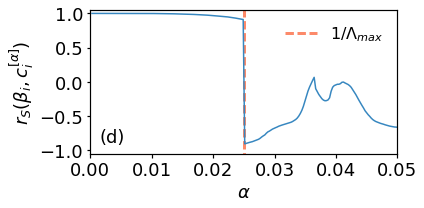

In [7]:
fig = plt.figure(figsize=(6,3));

plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 1.2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2
mycolor = [0.21568627, 0.52941176, 0.75424837, 1.        ]

ax = plt.subplot(111)

ax.axvline(x = 1./max(abs(numpy.linalg.eig(nx.to_numpy_matrix(G))[0])), 
           ymin = -1.05, ymax = 1.05,
           linestyle='--', color=plt.cm.Reds(0.4), lw=3, label=ur'$1/\Lambda_{max}$')

ax.plot(alphas, spcorr, '-', color=mycolor)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel(r"$\alpha$", size=18)
ax.set_ylabel(r"$r_{S}(\beta_i,c^{[\alpha]}_i)$", size=18)
ax.set_ylim(-1.05,1.05)
plt.yticks(np.arange(-1.,1.5, 0.5))
ax.set_xlim(min(alphas), max(alphas))
ax.legend(fontsize=16, frameon=False);
ax.annotate('(d)', xy=(0.03, 0.08), xycoords="axes fraction", fontsize=18);

plt.tight_layout()

In [ ]:
chosen_alpha = .6/max(abs(numpy.linalg.eig(nx.to_numpy_matrix(G))[0]))

In [64]:
df = pd.DataFrame() 
df['node_id'] = list(D_tmax.keys())
df['D_tmax'] = list(D_tmax.values())
df['alpha_c'] = list(get_alpha_centrality(G, alpha=chosen_alpha).values())
#Adding normalized centrality
df['normed_alpha_c'] = df['alpha_c']/df['alpha_c'].max()
#Adding fitted beta exponent (with the rough log method)
df['beta_exp_rough'] = betas.values()

#Saving
df.to_csv('../results/Real_nets/Jazz.csv', index=False, header=True, sep=',')

df.head()

,node_id,D_tmax,alpha_c,normed_alpha_c,beta_exp_rough
0,0,7845.851932,1.894941,0.423658,0.973660
1,1,8672.016710,2.616837,0.585054,0.984530
2,2,8646.432132,2.612366,0.584055,0.984209
3,3,8808.322175,2.876962,0.643211,0.986223
4,4,9036.301921,3.304332,0.738759,0.988998


# Plotting Fig. 4 

In [65]:
#Reading dataframes
Karate = pd.read_csv('../results/Real_nets/Karate_club.csv')
Twitter = pd.read_csv('../results/Real_nets/Twitter.csv')
Jazz = pd.read_csv('../results/Real_nets/Jazz.csv')
NetSci = pd.read_csv('../results/Real_nets/NetSci2006_collaboration.csv')

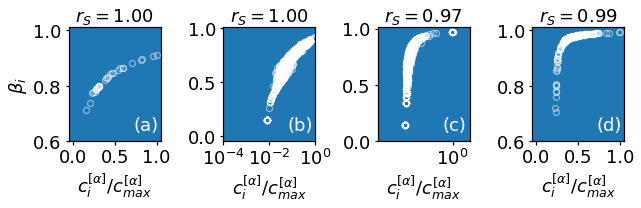

In [66]:
fig = plt.figure(figsize=(9,3));

plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 1.2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2
mycolor = [0.21568627, 0.52941176, 0.75424837, 1.        ]

backgroung_c = u'#1f77b4'#'white'
markercolor = 'white'#u'#1f77b4'#u'#ff7f0e'
mfc = 'None'
alpha = 0.5
ms = 6

###############################################################################################
ax = plt.subplot(141)###########################################################
ax.set_facecolor(backgroung_c)
x, y = Karate['normed_alpha_c'], Karate['beta_exp_rough']
ax.plot(x, y, 'o', mfc=mfc, mec=markercolor, mew=1.2, ms=ms, alpha=alpha)

ax.set_title(label="$r_{S}=%.2f$"%spearmanr(x, y)[0], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel(r"$\beta_i$", size=18)
ax.set_xlabel(r'$c^{[\alpha]}_i/c^{[\alpha]}_{max}$', size=18)
ax.set_xlim(-0.05,1.05)
ax.set_ylim(0.6,1.01)
ax.xaxis.set_ticks(np.arange(0, 1.1, 0.5))
ax.annotate('(a)', xy=(0.7, 0.1), xycoords="axes fraction", fontsize=18, color='white')
#ax.legend(loc='lower right', markerscale=0, handlelength=0, handletextpad=0, fontsize=16)

ax = plt.subplot(143)###########################################################
ax.set_facecolor(backgroung_c)
x, y = NetSci['normed_alpha_c'], NetSci['beta_exp_rough']
ax.plot(x, y, 'o', mfc=mfc, mec=markercolor,mew=1.2, ms=ms, alpha=alpha)

ax.set_title(label="$r_{S}=%.2f$"%spearmanr(x, y)[0], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel(r'$c^{[\alpha]}_i/c^{[\alpha]}_{max}$', size=18)
#ax.set_ylabel(ur"$\beta_i$", size=18)
ax.set_ylim(0.,1.01)
ax.yaxis.set_ticks([0.0,0.5,1.0])
ax.set_xscale('log')
ax.set_xlim(5e-2,2e0)
ax.minorticks_off()
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=2)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.annotate('(c)', xy=(0.7, 0.1), xycoords="axes fraction", fontsize=18, color='white')
#ax.legend(loc='lower right', markerscale=0, handlelength=0, handletextpad=0, fontsize=16)

ax = plt.subplot(142)###########################################################
ax.set_facecolor(backgroung_c)
x, y = Twitter['normed_alpha_c'], Twitter['beta_exp_rough']
ax.plot(x, y, 'o', mfc=mfc, mec=markercolor, mew=1.2, ms=ms, alpha=alpha)

ax.set_title(label="$r_{S}=%.2f$"%spearmanr(x, y)[0], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_xlim(-0.05,1.05)
ax.set_xlabel(r'$c^{[\alpha]}_i/c^{[\alpha]}_{max}$', size=18)
ax.set_ylim(-0.05,1.01)
ax.set_xscale('log')
ax.set_xlim(1e-4,1e0)
ax.xaxis.set_ticks([1e-4,1e-2,1e0])
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=4)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.annotate('(b)', xy=(0.7, 0.1), xycoords="axes fraction", fontsize=18, color='white')
#ax.legend(loc='lower right', markerscale=0, handlelength=0, handletextpad=0, fontsize=16)

ax = plt.subplot(144)###########################################################
ax.set_facecolor(backgroung_c)
x, y = Jazz['normed_alpha_c'], Jazz['beta_exp_rough']
ax.plot(x, y, 'o', mfc=mfc, mec=markercolor, mew=1.2, ms=ms, alpha=alpha)
ax.set_title(label="$r_{S}=%.2f$"%spearmanr(x, y)[0], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel(r'$c^{[\alpha]}_i/c^{[\alpha]}_{max}$', size=18)
ax.set_xlim(-0.05,1.05)
ax.set_ylim(0.6,1.01)
ax.xaxis.set_ticks(np.arange(0, 1.1, 0.5))
ax.annotate('(d)', xy=(0.7, 0.1), xycoords="axes fraction", fontsize=18, color='white')
#ax.legend(loc='lower right', markerscale=0, handlelength=0, handletextpad=0, fontsize=16)
###############################################################################################

plt.tight_layout()

#filename = "../figures/spearman_corr_real_nets.pdf"
#plt.savefig(filename, bbox_inches='tight', dpi=150)